In [1]:
import sys
sys.path.append("..")

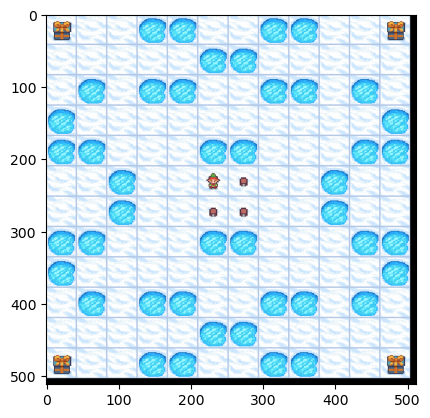

In [2]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt

grid_size = 12
grid_shape = (grid_size, grid_size)
env_description = generate_random_map(size=grid_size//2, p=0.8)
#env_description = list(map(lambda row: row.replace("F", "S"), env_description))
# mirror map both vertically and horizontally
env_description = [row[::-1]+ row for row in env_description[::-1] + env_description]

env = gym.make(
    "FrozenLake-v1",
    desc=env_description,
    is_slippery=False,
    render_mode="rgb_array",
)

env.reset()
plt.imshow(env.render())

In [3]:
from mango.concepts import Int2CoordConcept
from mango.actions import GridCompatibility

base_concept = Int2CoordConcept(grid_shape, cell_shape=(1, 1))
concepts = [
    Int2CoordConcept(grid_shape, cell_shape=(2, 2)),
    Int2CoordConcept(grid_shape, cell_shape=(4, 4)),
]
action_compatabilities = [
    GridCompatibility(),
    GridCompatibility(),
]

In [4]:
from mango.mango import Mango

mango = Mango(
    environment=env,
    concepts=concepts,
    action_compatibilities=action_compatabilities,
    base_concept=base_concept,
)
print(mango)
print(f"{mango.option_space=}")

c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Mango(
  (0): MangoEnv(
    (concept): Int2CoordConcept(global_shape=(12, 12), cell_shape=(1, 1))
    (environment): <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
  )
  (1): MangoEnv(
    (concept): Int2CoordConcept(global_shape=(12, 12), cell_shape=(1, 1))
    (environment): <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
  )
  (2): MangoLayer(
    (concept): Int2CoordConcept(global_shape=(12, 12), cell_shape=(2, 2))
    (act_comp): GridCompatibility()
    (policy): DQnetPolicyMapper(
      (0): DQnetPolicy(action_space=Discrete(4))
      (1): DQnetPolicy(action_space=Discrete(4))
      (2): DQnetPolicy(action_space=Discrete(4))
      (3): DQnetPolicy(action_space=Discrete(4))
    )
  )
  (3): MangoLayer(
    (concept): Int2CoordConcept(global_shape=(12, 12), cell_shape=(4, 4))
    (act_comp): GridCompatibility()
    (policy): DQnetPolicyMapper(
      (0): DQnetPolicy(action_space=Discrete(4))
      (1): DQnetPolicy(action_sp

c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
import tqdm.notebook as tqdm

for _ in tqdm.trange(10):
    for layer in [1,2]:
        N = int(100)
        for i in tqdm.trange(N):
            epsilon = pow(100,((N-i)/N-1))-1/100
            mango.explore(layer_idx=layer, max_steps=5, epsilon=epsilon)
            mango.train(layer_idx=layer)
           

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

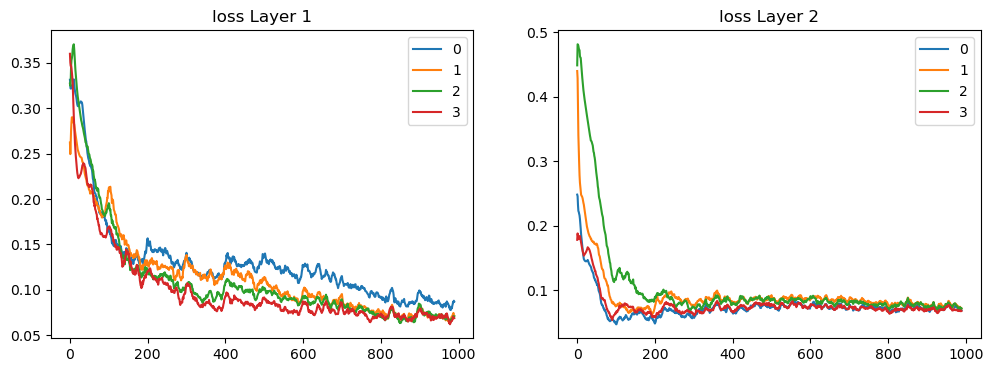

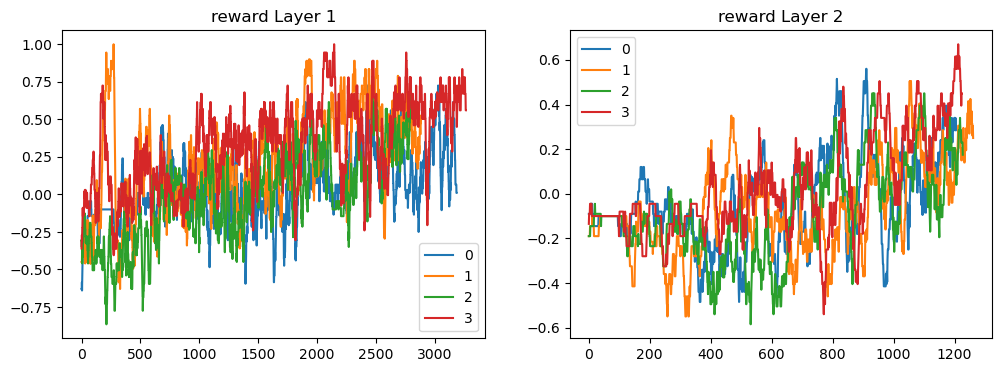

In [6]:
from mango.utils import smooth

plt.figure(figsize=(12, 4))
for i, layer in enumerate(mango.abstract_layers):
    plt.subplot(1, len(mango.abstract_layers), i + 1)
    plt.title(f"loss Layer {i+1}")
    for comand, policy in layer.policy.policies.items():
        plt.plot(smooth(policy.loss_log), label=comand)
    plt.legend()    
    
plt.figure(figsize=(12, 4))
for i, layer in enumerate(mango.abstract_layers):
    plt.subplot(1, len(mango.abstract_layers), i + 1)
    plt.title(f"reward Layer {i+1}")
    for comand, log in enumerate(layer.debug_log):
        plt.plot(smooth(log, 20), label=comand)
    plt.legend()   

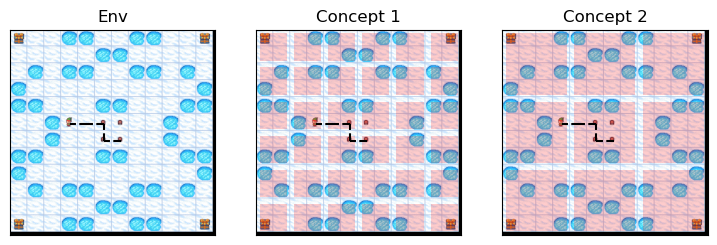

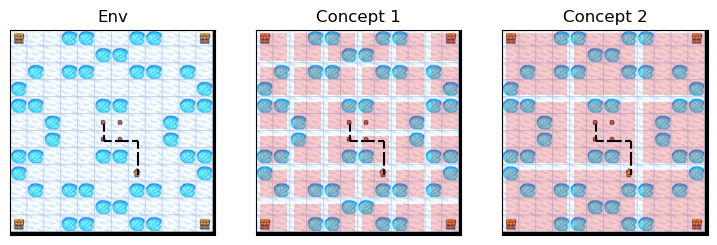

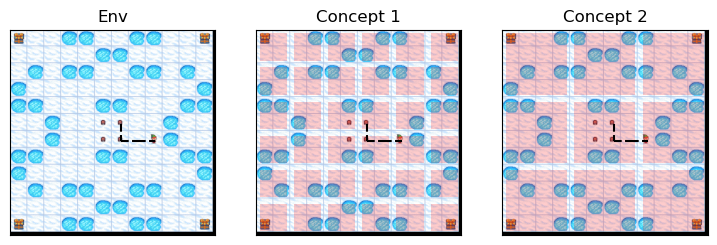

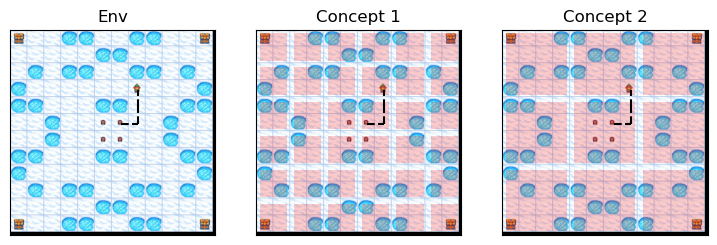

In [7]:
from mango.utils import plot_grid, plot_trajectory

for action in [0,1,2,3]:
    start_state, info = mango.reset()
    end_state, reward, trunc, term, info = mango.execute_option(action=action, layer_idx=2)
    img = env.render()

    plt.figure(figsize=((1 + len(concepts)) * 3, 3))
    for i, concept in enumerate([None] + concepts):
        plt.subplot(1, len(concepts) + 1, 1 + i)
        plt.title("Env" if concept is None else f"Concept {i}")
        plt.imshow(img)  # type: ignore
        if concept is not None:
            plot_grid(grid_shape, concept.cell_shape) # type: ignore
        plot_trajectory(start_state, info["mango:trajectory"], grid_shape)
        plt.xticks([])
        plt.yticks([])
    plt.show()